# Torch hello world

Load cifar10 dataset and use a simple network to classify the images.

## Load data

In [1]:
require 'paths'

if (not paths.filep("../../dataset/cifar10/cifar10torchsmall.zip")) then
    os.execute('wget -c https://s3.amazonaws.com/torch7/data/cifar10torchsmall.zip')
    os.execute('unzip cifar10torchsmall.zip')
    os.execute('mkdir -p ../../dataset/cifar10/')
    os.execute('mv cifar10* ../../dataset/cifar10/')
end

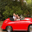

automobile	


In [2]:
trainset = torch.load('../../dataset/cifar10/cifar10-train.t7')
testset = torch.load('../../dataset/cifar10/cifar10-test.t7')

classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

itorch.image(trainset.data[100])
print(classes[trainset.label[100]])

it is important to define a function to iterate through the dataset

In [3]:
setmetatable(trainset, 
    {
        __index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                  end
    }
);

In [4]:
trainset.data = trainset.data:double()

function trainset:size() 
    return self.data:size(1) 
end

print(trainset:size()) -- just to test

10000	


## Normalize the data

In [5]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future

for i=1, 3 do
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean()
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std()
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end
print("trainset mean", mean)
print("trainset stdv", stdv)

trainset mean	{
  1 : 125.83175029297
  2 : 123.26066621094
  3 : 114.03068681641
}
trainset stdv	{
  1 : 63.143400842609
  2 : 62.369209019002
  3 : 66.965808411114
}


In [6]:
testset.data = testset.data:double()
for i=1,3 do
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

## Convolutional network

In [7]:
require 'nn'

net = nn.Sequential()

net:add(nn.SpatialConvolution(3, 24, 5, 5))
net:add(nn.ReLU())
net:add(nn.SpatialMaxPooling(2, 2, 2, 2))

net:add(nn.SpatialConvolution(24, 32, 5, 5))
net:add(nn.ReLU())             
net:add(nn.SpatialMaxPooling(2, 2, 2, 2))
net:add(nn.View(32*5*5)) 

net:add(nn.Linear(32*5*5, 200))
net:add(nn.ReLU())
net:add(nn.Linear(200, 150))
net:add(nn.ReLU())
net:add(nn.Linear(150, 84))
net:add(nn.ReLU())
net:add(nn.Linear(84, 10))
net:add(nn.LogSoftMax())

add loss function

In [8]:
-- negative log-likelihood for LogSoftMax
criterion = nn.ClassNLLCriterion()

### CUDA
use gpu device to speed up the process

In [9]:
require 'cunn'
net = net:cuda()
criterion = criterion:cuda()
trainset.data = trainset.data:cuda()
trainset.label = trainset.label:cuda()
testset.data = testset.data:cuda()

In [10]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 12

trainer:train(trainset)

# StochasticGradient: training	


# current error = 2.2655292223334	


# current error = 1.9080044418573	


# current error = 1.6949004646182	


# current error = 1.5637687342286	


# current error = 1.4521619621992	


# current error = 1.3515260339022	


# current error = 1.2610507487059	


# current error = 1.1746295476079	


# current error = 1.0898579795241	


# current error = 0.99719185898304	


# current error = 0.9030219594121	


# current error = 0.80424278362989	
# StochasticGradient: you have reached the maximum number of iterations	


# training error = 0.80424278362989	


## Test the model

horse	


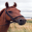

In [11]:
print(classes[testset.label[100]])
itorch.image(testset.data[100])
predicted = net:forward(testset.data[100])

the output of the network is Log-Probabilities. To convert them to probabilities, you have to take e^x

In [12]:
predicted = predicted:exp()

for i=1,predicted:size(1) do
    print(classes[i], predicted[i])
end

airplane	0.003876993432641	
automobile	3.015756374225e-05	
bird	0.003632259555161	
cat	0.048161216080189	
deer	0.020850382745266	
dog	0.045400779694319	
frog	0.0028227888979018	
horse	0.87369406223297	
ship	0.00032634218223393	


truck	0.0012048981152475	


## Check accuracy

In [13]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end

print(correct, 100*correct/10000 .. ' % ')

4980	49.8 % 	


In [14]:
correct = 0
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
n = testset.data:size(1)

for i=1,n do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end

for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	38.4 %	


automobile	35.4 %	
bird	17.2 %	
cat	45.5 %	
deer	22.1 %	
dog	60.9 %	
frog	49.4 %	
horse	74.6 %	
ship	82.2 %	
truck	72.3 %	
